In [21]:
import sys
import config
sys.path.append(config.root)
from pathlib import Path
from utils.system_status import get_system_status
from utils.read_alt06 import read_atl06


In [22]:
data_dir = config.root + '/data/icesat2'
data_home = Path(data_dir)
files = list(data_home.glob('*.h5'))
print('Total number of files:', len(files))
# !h5ls -r {files[0]}


Total number of files: 12


In [23]:
# print(get_system_status())

I am currently running on Darwin version 20.3.0.  
This system is named luoxins-MacBook-Pro.local 
It has 8 CPU cores.  
It has 16 Gigabytes of RAM.  
Current disk_percent is 4.1 percent.  
Current CPU utilization is 15.3 percent.  
Current memory utilization is 67.5 percent. 
it's running since Tuesday 20. April 2021. 



In [4]:
## read_atl06: specify data reading and good data filtering
outdir = Path(config.root + '/data/icesat2/subset')
njobs = 8
bbox = None  #[-1124782, 81623, -919821, -96334]  # Kamb bounding box
outdir.mkdir(exist_ok=True)
if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, outdir, bbox) for f in files]
else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, outdir, bbox) for f in files)


running in parallel (8 jobs) ...
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    2.8s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    3.5s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    3.7s finished


In [5]:
outfiles = list(outdir.glob('*.h5'))
print('Total number of files:', len(outfiles))
!h5ls -r {outfiles[0]}


Total number of files: 72
/                        Group
/dac                     Dataset {2601}
/dh_fit_dx               Dataset {2601}
/f_sn                    Dataset {2601}
/h_li                    Dataset {2601}
/h_rb                    Dataset {2601}
/is_asc                  Dataset {2601}
/lat                     Dataset {2601}
/lon                     Dataset {2601}
/q_flag                  Dataset {2601}
/s_fg                    Dataset {2601}
/s_li                    Dataset {2601}
/snr                     Dataset {2601}
/t_dt                    Dataset {2601}
/t_gps                   Dataset {2601}
/t_year                  Dataset {2601}
/tide_earth              Dataset {2601}
/tide_load               Dataset {2601}
/tide_ocean              Dataset {2601}
/tide_pole               Dataset {2601}
/x                       Dataset {2601}
/y                       Dataset {2601}


In [20]:
import h5py
import numpy as np
import dask.dataframe as dd

def read_h5(fname, vnames=[]):
    """Read a list of vars [v1, v2, ..] -> 2D."""
    with h5py.File(fname, 'r') as f:
        return np.column_stack([f[v][()] for v in vnames])

files = list(outdir.glob('*.h5'))

# Variables we want to plot
vnames = ['lon', 'lat', 'h_li']
# vnames = ['x', 'y', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
print(df.head())

Number of files: 72
Number of points: 257173
         lon        lat         h_li
0  80.653599  35.807864  4377.303223
1  80.653579  35.807684  4383.888672
2  80.649281  35.769360  5358.392090
3  80.648725  35.765048  5111.548340
4  80.648661  35.764508  5107.095215


In [24]:
# df.to_csv(str(outdir)+'/points-*.csv')  # -> N csv files


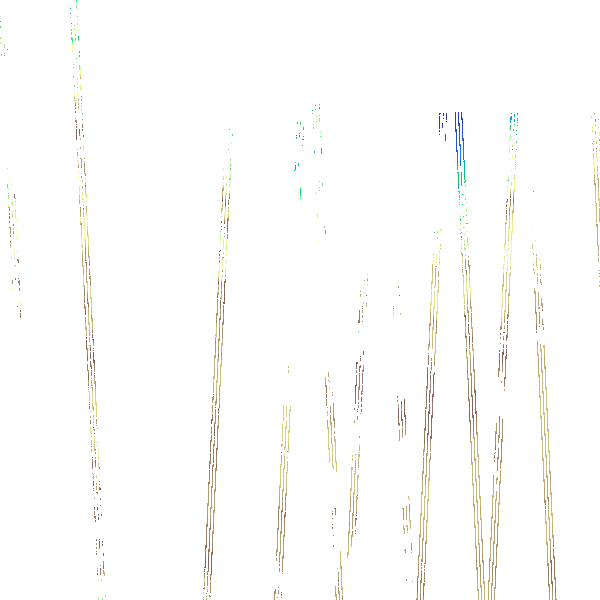

In [25]:
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.cm import terrain as cmap
# df = dd.read_csv(str(outdir)+'/*.csv')
pts = ds.Canvas(plot_width=600, plot_height=600)
agg = pts.points(df, 'lon', 'lat', ds.mean('h_li'))
# agg = pts.points(df, 'x', 'y', ds.mean('h_li'))
img = tf.shade(agg, cmap=cmap, how='linear')
img
